# Assignment 3: Improving the Pipeline

## Part 2: Analysis

The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting. This prediction is being done at the time of posting, so you can only use data available to you at that time. The data is a file that has one row for each project posted with a column for "date_posted" (the date the project was posted) and a column for "datefullyfunded" (the date the project was fully funded - assumption for this assignment is that all projects were fully funded eventually). The task is to predict if a project on donorschoose will not get fully funded within 60 days of posting.

The data spans Jan 1, 2012 to Dec 31, 2013. You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). The training sets should be everything from 1/1/12 to the beginning of the test set.

In [1]:
import pipeline_v2 as pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import SelectKBest, chi2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [2]:
# Import data
df = pd.read_csv('data/projects_2012_2013.csv', index_col='projectid')

# Create target  
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['not_funded_within_60days'] = np.where(df['datefullyfunded'] - df['date_posted'] > pd.Timedelta('60 days'), 1, 0)
target_col = ['not_funded_within_60days']

# Create features  
for var in ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']: 
    df[var] = np.where(df[var] == 't', 1, 0)
df['teacher_female'] = np.where(np.isin(df['teacher_prefix'], ['Mrs.', 'Ms.']), 1, 0)
df['total_price_over500'] = np.where(df['total_price_including_optional_support'] > 500, 1, 0)
df['students_reached_over30'] = np.where(df['students_reached'] > 30, 1, 0)
df = pd.get_dummies(df, columns=['school_metro', 'resource_type', 'poverty_level', 'grade_level'])

# Identify best features
all_features = ['school_charter', 'school_magnet', 'teacher_female', 
                'eligible_double_your_impact_match', 'total_price_over500', 
                'students_reached_over30', 'school_metro_rural', 'school_metro_suburban', 
                'school_metro_urban','poverty_level_low poverty', 
                'poverty_level_moderate poverty', 'poverty_level_high poverty', 
                'poverty_level_highest poverty', 'grade_level_Grades PreK-2', 
                'grade_level_Grades 3-5', 'grade_level_Grades 6-8', 
                'grade_level_Grades 9-12', 'resource_type_Books', 'resource_type_Other', 
                'resource_type_Supplies', 'resource_type_Technology', 'resource_type_Trips', 
                'resource_type_Visitors']

best_features = SelectKBest(chi2, k=5).fit(df[all_features], df[target_col]).get_support()
list(df[all_features].columns[best_features])

['eligible_double_your_impact_match',
 'total_price_over500',
 'resource_type_Books',
 'resource_type_Supplies',
 'resource_type_Technology']

### General Model Parameters
Per the instructions, the problem is to predict if a project will not get funded within 60 days of posting, meaning my target is not_funded_within_60days. For reference, around 29% of projects in the dataset were not funded within 60 days of posting.

As a simplifying heuristic, I used sklearn's SelectKBest to choose 5 features to include in my subsequent models: 
- eligible_double_your_impact_match
- total_price_over500
- resource_type_Books
- resource_type_Supplies
- resource_type_Technology

Also per the instructions, I create three tests (using a rolling window of 6 months with data spanning from Jan 1, 2012 to Dec 31, 2013). The training data for each split is all data before the test set. Thus, my three validation splits are as follows: 
- Split 1: Training from Jan 1, 2012 to July 1, 2012, Testing from July 1, 2012 to Jan 1, 2013
- Split 2: Training from Jan 1, 2012 to Jan 1, 2013, Testing from Jan 1, 2013 to July 1, 2013
- Split 3: Training from Jan 1, 2012 to July 1, 2013, Testing from July 1, 2013 to Jan 1, 2014 

In [3]:
# Specify model parameters 
feature_cols = ['eligible_double_your_impact_match',
                'total_price_over500',
                'resource_type_Books',
                'resource_type_Supplies',
                'resource_type_Technology']
target_col = ['not_funded_within_60days']
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
splits = [[1, '2012-07-01', '2013-01-01'],
          [2, '2013-01-01', '2013-07-01'], 
          [3, '2013-07-01', '2014-01-01']]

### Baseline
The baseline function in my pipeline creates a simple baseline model using sklearn's DummyClassifier. It includes a parameter for the prediction strategy (here, I used the most frequent label in the training set).

In [4]:
# Baseline 
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    evaluation_dict = pipeline.build_Baseline(
        X_train, y_train.values.ravel(), X_test, y_test, strategy='most_frequent') 
    evaluation_row = [s[0],
                      evaluation_dict['accuracy'], 
                      evaluation_dict['precision'], 
                      evaluation_dict['recall'], 
                      evaluation_dict['f1'], 
                      evaluation_dict['confusion_matrix']] 
    evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 'F1', 
                                        'Confusion Matrix [TN, FP, FN, TP]']) 

,Temporal Split,Accuracy,Precision,Recall,F1,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
1,2,0.685059,0.0,0.0,0.0,"[14787, 0, 6798, 0]"
2,3,0.715353,0.0,0.0,0.0,"[31595, 0, 12572, 0]"


### Logistic Regression
The logistic regression function in my pipeline includes the following parameters: 
- optimization algorithm (liblinear)
- penalization norm (l1)
- regularization strength (1) 

In [5]:
# Logistic Regression 
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    for t in thresholds: 
        pred_scores, pred_labels = pipeline.build_LogReg(
            X_train, y_train.values.ravel(), X_test, solver='liblinear', penalty='l1', C=1, threshold=t) 
        evaluation_dict = pipeline.evaluate(y_test, pred_labels, pred_scores, include_ROC=True)
        evaluation_row = [s[0], t, 
                          evaluation_dict['accuracy'], 
                          evaluation_dict['precision'], 
                          evaluation_dict['recall'], 
                          evaluation_dict['f1'], 
                          evaluation_dict['roc_auc'], 
                          evaluation_dict['confusion_matrix']] 
        evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Threshold', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 'F1', 
                                        'AUC_ROC', 
                                        'Confusion Matrix [TN, FP, FN, TP]']) 

,Temporal Split,Threshold,Accuracy,Precision,Recall,F1,AUC_ROC,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.01,0.256928,0.256928,1.000000,0.408819,0.632162,"[0, 24401, 0, 8437]"
1,1,0.02,0.256928,0.256928,1.000000,0.408819,0.632162,"[0, 24401, 0, 8437]"
2,1,0.05,0.256928,0.256928,1.000000,0.408819,0.632162,"[0, 24401, 0, 8437]"
3,1,0.10,0.256928,0.256928,1.000000,0.408819,0.632162,"[0, 24401, 0, 8437]"
4,1,0.20,0.401577,0.285894,0.887401,0.432462,0.632162,"[5700, 18701, 950, 7487]"
5,1,0.30,0.574578,0.333112,0.654498,0.441513,0.632162,"[13346, 11055, 2915, 5522]"
6,1,0.50,0.743072,0.000000,0.000000,0.000000,0.632162,"[24401, 0, 8437, 0]"
7,2,0.01,0.314941,0.314941,1.000000,0.479019,0.640371,"[0, 14787, 0, 6798]"
8,2,0.02,0.314941,0.314941,1.000000,0.479019,0.640371,"[0, 14787, 0, 6798]"
9,2,0.05,0.314941,0.314941,1.000000,0.479019,0.640371,"[0, 14787, 0, 6798]"


### K-Nearest Neighbor
The k-nearest neighbor function in my pipeline includes the following parameters: 
- number of neighbors (5)
- distance metric (euclidian)
- weight function (distance)

In [6]:
# K Nearest Neighbor
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    for t in thresholds: 
        pred_scores, pred_labels = pipeline.build_KNN(
            X_train, y_train.values.ravel(), X_test, n_neighbors=5, distance_metric='euclidean', weight='distance', threshold=t)
        evaluation_dict = pipeline.evaluate(y_test, pred_labels, pred_scores, include_ROC=True)
        evaluation_row = [s[0], t, 
                          evaluation_dict['accuracy'], 
                          evaluation_dict['precision'], 
                          evaluation_dict['recall'], 
                          evaluation_dict['f1'], 
                          evaluation_dict['roc_auc'], 
                          evaluation_dict['confusion_matrix']] 
        evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Threshold', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 
                                        'F1', 
                                        'AUC_ROC', 
                                        'Confusion Matrix [TN, FP, FN, TP]']) 

,Temporal Split,Threshold,Accuracy,Precision,Recall,F1,AUC_ROC,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.01,0.351605,0.263024,0.845561,0.401237,0.522385,"[4412, 19989, 1303, 7134]"
1,1,0.02,0.351605,0.263024,0.845561,0.401237,0.522385,"[4412, 19989, 1303, 7134]"
2,1,0.05,0.351605,0.263024,0.845561,0.401237,0.522385,"[4412, 19989, 1303, 7134]"
3,1,0.10,0.351605,0.263024,0.845561,0.401237,0.522385,"[4412, 19989, 1303, 7134]"
4,1,0.20,0.607589,0.275869,0.324523,0.298225,0.522385,"[17214, 7187, 5699, 2738]"
5,1,0.30,0.607589,0.275869,0.324523,0.298225,0.522385,"[17214, 7187, 5699, 2738]"
6,1,0.50,0.721451,0.295035,0.060567,0.100502,0.522385,"[23180, 1221, 7926, 511]"
7,2,0.01,0.470419,0.351820,0.809061,0.490393,0.561804,"[4654, 10133, 1298, 5500]"
8,2,0.02,0.470419,0.351820,0.809061,0.490393,0.561804,"[4654, 10133, 1298, 5500]"
9,2,0.05,0.470419,0.351820,0.809061,0.490393,0.561804,"[4654, 10133, 1298, 5500]"


### Decision Tree
The decision tree classifier function in my pipeline includes the following parameters: 
- split quality criterion (entropy)
- maximum tree depth (5)
- minumim samples required for a leaf (10)

In [7]:
# Decision Tree 
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    for t in thresholds: 
        pred_scores, pred_labels = pipeline.build_DecTree(
            X_train, y_train.values.ravel(), X_test, criterion='entropy', max_depth=5, min_samples_leaf=10, threshold=t)
        evaluation_dict = pipeline.evaluate(y_test, pred_labels, pred_scores, include_ROC=True)
        evaluation_row = [s[0], t, 
                          evaluation_dict['accuracy'], 
                          evaluation_dict['precision'], 
                          evaluation_dict['recall'], 
                          evaluation_dict['f1'], 
                          evaluation_dict['roc_auc'], 
                          evaluation_dict['confusion_matrix']] 
        evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Threshold', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 
                                        'F1', 
                                        'AUC_ROC', 
                                        'Confusion Matrix [TN, FP, FN, TP]']) 

,Temporal Split,Threshold,Accuracy,Precision,Recall,F1,AUC_ROC,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.01,0.256928,0.256928,1.000000,0.408819,0.634065,"[0, 24401, 0, 8437]"
1,1,0.02,0.256928,0.256928,1.000000,0.408819,0.634065,"[0, 24401, 0, 8437]"
2,1,0.05,0.256928,0.256928,1.000000,0.408819,0.634065,"[0, 24401, 0, 8437]"
3,1,0.10,0.256928,0.256928,1.000000,0.408819,0.634065,"[0, 24401, 0, 8437]"
4,1,0.20,0.374231,0.281435,0.924262,0.431484,0.634065,"[4491, 19910, 639, 7798]"
5,1,0.30,0.567056,0.330955,0.670618,0.443191,0.634065,"[12963, 11438, 2779, 5658]"
6,1,0.50,0.743072,0.000000,0.000000,0.000000,0.634065,"[24401, 0, 8437, 0]"
7,2,0.01,0.314941,0.314941,1.000000,0.479019,0.639057,"[0, 14787, 0, 6798]"
8,2,0.02,0.314941,0.314941,1.000000,0.479019,0.639057,"[0, 14787, 0, 6798]"
9,2,0.05,0.314941,0.314941,1.000000,0.479019,0.639057,"[0, 14787, 0, 6798]"


### Support Vector Machine
The linear support vector function in my pipeline includes the following parameters: 
- stopping criteria tolerance (1e-4)
- loss function (hinge)
- penalty perameter (10**-1) 

In [8]:
# Support Vector Machine
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    for t in thresholds: 
        pred_scores, pred_labels = pipeline.build_SVM(
            X_train, y_train.values.ravel(), X_test, tol=1e-4, loss='hinge', C=10**-1, threshold=t)
        
        evaluation_dict = pipeline.evaluate(y_test, pred_labels, pred_scores, include_ROC=False)
        evaluation_row = [s[0], t, 
                          evaluation_dict['accuracy'], 
                          evaluation_dict['precision'], 
                          evaluation_dict['recall'], 
                          evaluation_dict['f1'], 
                          evaluation_dict['confusion_matrix']] 
        evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Threshold', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 
                                        'F1', 
                                        'Confusion Matrix [TN, FP, FN, TP]']) 

,Temporal Split,Threshold,Accuracy,Precision,Recall,F1,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.01,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
1,1,0.02,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
2,1,0.05,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
3,1,0.10,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
4,1,0.20,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
5,1,0.30,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
6,1,0.50,0.743072,0.0,0.0,0.0,"[24401, 0, 8437, 0]"
7,2,0.01,0.685059,0.0,0.0,0.0,"[14787, 0, 6798, 0]"
8,2,0.02,0.685059,0.0,0.0,0.0,"[14787, 0, 6798, 0]"
9,2,0.05,0.685059,0.0,0.0,0.0,"[14787, 0, 6798, 0]"


### Random Forest (Bagging)
The random forest classifier (a bagging algorithm) function in my pipeline includes the following parameters: 
- number of trees in the forest (10) 
- split quality criterion (entropy)
- maximum tree depth (5)
- minumim samples required for a leaf (10)

In [9]:
# Random Forest 
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    for t in thresholds: 
        pred_scores, pred_labels = pipeline.build_RandForest(
            X_train, y_train.values.ravel(), X_test, n_estimators=10, criterion='entropy', max_depth=5, min_samples_leaf=10, threshold=t)
        evaluation_dict = pipeline.evaluate(y_test, pred_labels, pred_scores, include_ROC=True)
        evaluation_row = [s[0], t, 
                          evaluation_dict['accuracy'], 
                          evaluation_dict['precision'], 
                          evaluation_dict['recall'], 
                          evaluation_dict['f1'], 
                          evaluation_dict['roc_auc'], 
                          evaluation_dict['confusion_matrix']] 
        evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Threshold', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 'F1', 
                                        'AUC_ROC', 
                                        'Confusion Matrix [TN, FP, FN, TP]']) 

,Temporal Split,Threshold,Accuracy,Precision,Recall,F1,AUC_ROC,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.01,0.256928,0.256928,1.000000,0.408819,0.634027,"[0, 24401, 0, 8437]"
1,1,0.02,0.256928,0.256928,1.000000,0.408819,0.634065,"[0, 24401, 0, 8437]"
2,1,0.05,0.256928,0.256928,1.000000,0.408819,0.634065,"[0, 24401, 0, 8437]"
3,1,0.10,0.256928,0.256928,1.000000,0.408819,0.634172,"[0, 24401, 0, 8437]"
4,1,0.20,0.374231,0.281435,0.924262,0.431484,0.632986,"[4491, 19910, 639, 7798]"
5,1,0.30,0.567056,0.330955,0.670618,0.443191,0.634028,"[12963, 11438, 2779, 5658]"
6,1,0.50,0.743072,0.000000,0.000000,0.000000,0.634065,"[24401, 0, 8437, 0]"
7,2,0.01,0.314941,0.314941,1.000000,0.479019,0.638937,"[0, 14787, 0, 6798]"
8,2,0.02,0.314941,0.314941,1.000000,0.479019,0.639054,"[0, 14787, 0, 6798]"
9,2,0.05,0.314941,0.314941,1.000000,0.479019,0.639560,"[0, 14787, 0, 6798]"


### Gradient Boosting
The gradient boosting classifier function in my pipeline includes the following parameters: 
- number of boosting stages (100) 
- learning rate contribution of each tree (0.1)

In [10]:
# Gradient Boosting
evaluation_table = [] 
for s in splits: 
    X_train, X_test, y_train, y_test = pipeline.temporal_split(
        df, feature_cols, target_col, 'date_posted', s[1], s[2])
    for t in thresholds: 
        pred_scores, pred_labels = pipeline.build_GradBoost(
            X_train, y_train.values.ravel(), X_test, n_estimators=100, learning_rate=0.1, threshold=t)
        evaluation_dict = pipeline.evaluate(y_test, pred_labels, pred_scores, include_ROC=True)
        evaluation_row = [s[0], t, 
                          evaluation_dict['accuracy'], 
                          evaluation_dict['precision'], 
                          evaluation_dict['recall'], 
                          evaluation_dict['f1'], 
                          evaluation_dict['roc_auc'], 
                          evaluation_dict['confusion_matrix']] 
        evaluation_table.append(evaluation_row)

pd.DataFrame(evaluation_table, columns=['Temporal Split', 
                                        'Threshold', 
                                        'Accuracy', 
                                        'Precision', 
                                        'Recall', 'F1', 
                                        'AUC_ROC', 
                                        'Confusion Matrix [TN, FP, FN, TP]'])         

,Temporal Split,Threshold,Accuracy,Precision,Recall,F1,AUC_ROC,"Confusion Matrix [TN, FP, FN, TP]"
0,1,0.01,0.256928,0.256928,1.000000,0.408819,0.634172,"[0, 24401, 0, 8437]"
1,1,0.02,0.256928,0.256928,1.000000,0.408819,0.634172,"[0, 24401, 0, 8437]"
2,1,0.05,0.256928,0.256928,1.000000,0.408819,0.634172,"[0, 24401, 0, 8437]"
3,1,0.10,0.256928,0.256928,1.000000,0.408819,0.634172,"[0, 24401, 0, 8437]"
4,1,0.20,0.374231,0.281435,0.924262,0.431484,0.634172,"[4491, 19910, 639, 7798]"
5,1,0.30,0.567056,0.330955,0.670618,0.443191,0.634172,"[12963, 11438, 2779, 5658]"
6,1,0.50,0.743072,0.000000,0.000000,0.000000,0.634172,"[24401, 0, 8437, 0]"
7,2,0.01,0.314941,0.314941,1.000000,0.479019,0.638937,"[0, 14787, 0, 6798]"
8,2,0.02,0.314941,0.314941,1.000000,0.479019,0.638937,"[0, 14787, 0, 6798]"
9,2,0.05,0.314941,0.314941,1.000000,0.479019,0.638937,"[0, 14787, 0, 6798]"


### Precision-Recall and ROC Curves
My pipeline also includes functions for plotting Precision-Recall and ROC Curves, which can be plotted for any of the models (and incorporated into any of the loops). An example of each is provided. 

Precision-Recall Curve:


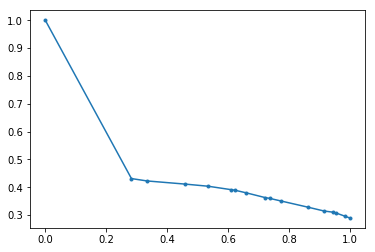

ROC Curve:


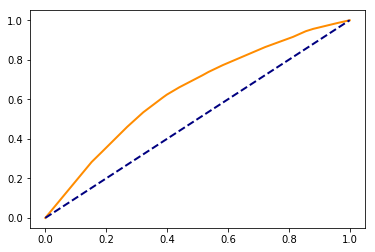

In [11]:
# Precision-Recall and Precision-Recall Curves 
X_train, X_test, y_train, y_test = pipeline.split(df, feature_cols, target_col, 0.2, 123)
pred_scores, pred_labels = pipeline.build_LogReg(
    X_train, y_train.values.ravel(), X_test, solver='liblinear', penalty='l1', C=1, threshold=0.3)     
pipeline.precision_recall(y_test, pred_scores)
pipeline.roc(y_test, pred_scores)